<a href="https://colab.research.google.com/github/sourcecode369/Kaggle-Kernels/blob/master/Categorical_Encoding_2_Libffm_Stratified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle 
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c cat-in-the-dat-ii
!kaggle datasets download -d ogrellier/libffm-binaries

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 31% 5.00M/16.1M [00:00<00:00, 32.7MB/s]
100% 16.1M/16.1M [00:00<00:00, 63.9MB/s]
  0% 0.00/871k [00:00<?, ?B/s]
100% 871k/871k [00:00<00:00, 121MB/s]
 70% 17.0M/24.3M [00:00<00:00, 28.8MB/s]
100% 24.3M/24.3M [00:00<00:00, 38.3MB/s]
  0% 0.00/51.4k [00:00<?, ?B/s]
100% 51.4k/51.4k [00:00<00:00, 76.3MB/s]


In [3]:
!ls -GFlash --color

total 42M
4.0K drwxr-xr-x 1 root 4.0K Mar 29 09:43 ./
4.0K drwxr-xr-x 1 root 4.0K Mar 29 09:40 ../
4.0K drwxr-xr-x 1 root 4.0K Mar 25 16:11 .config/
 52K -rw-r--r-- 1 root  52K Mar 29 09:43 libffm-binaries.zip
4.0K drwxr-xr-x 1 root 4.0K Mar 18 16:23 sample_data/
872K -rw-r--r-- 1 root 872K Mar 29 09:43 sample_submission.csv.zip
 17M -rw-r--r-- 1 root  17M Mar 29 09:43 test.csv.zip
 25M -rw-r--r-- 1 root  25M Mar 29 09:43 train.csv.zip


In [4]:
import glob 
zip_files = glob.glob("*.zip")
import zipfile
for file in zip_files:
  with zipfile.ZipFile(file,'r') as zf:
    zf.printdir()
    print(" Extracting.. ")
    zf.extractall()
    print("Done.")

File Name                                             Modified             Size
ffm-predict                                    2020-02-08 11:42:08        59064
ffm-train                                      2020-02-08 11:42:08        67440
 Extracting.. 
Done.
File Name                                             Modified             Size
test.csv                                       2019-12-31 22:00:54     56141294
 Extracting.. 
Done.
File Name                                             Modified             Size
sample_submission.csv                          2019-12-31 22:00:54      4400010
 Extracting.. 
Done.
File Name                                             Modified             Size
train.csv                                      2019-12-31 22:00:54     85299544
 Extracting.. 
Done.


In [5]:
!rm -r libffm-binaries.zip
!rm -r train.csv.zip
!rm -r test.csv.zip
!rm -r sample_submission.csv.zip

!ls -GFlash --color

total 140M
4.0K drwxr-xr-x 1 root 4.0K Mar 29 09:55 ./
4.0K drwxr-xr-x 1 root 4.0K Mar 29 09:40 ../
4.0K drwxr-xr-x 1 root 4.0K Mar 25 16:11 .config/
 60K -rw-r--r-- 1 root  58K Mar 29 09:55 ffm-predict
 68K -rw-r--r-- 1 root  66K Mar 29 09:55 ffm-train
4.0K drwxr-xr-x 1 root 4.0K Mar 18 16:23 sample_data/
4.2M -rw-r--r-- 1 root 4.2M Mar 29 09:55 sample_submission.csv
 54M -rw-r--r-- 1 root  54M Mar 29 09:55 test.csv
 82M -rw-r--r-- 1 root  82M Mar 29 09:55 train.csv


In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rankdata
import os
import gc
gc.enable()
gc.collect()

0

In [0]:
N_SPLITS = 50
SEED = 2020

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test['target'] = 1

In [0]:
features = [_f for _f in train if _f not in ['id','target']]
def factor_encoding(train, test):
    assert sorted(train.columns) == sorted(test.columns)
    full = pd.concat([train, test], axis=0, sort=False)
    for f in full:
        full[f], _ = pd.factorize(full[f])
        full[f] += 1  
    return full.iloc[:train.shape[0]], full.iloc[train.shape[0]:]

train_f, test_f = factor_encoding(train[features], test[features])

In [0]:
class LibFFMEncoder(object):
    def __init__(self):
        self.encoder = 1
        self.encoding = {}

    def encode_for_libffm(self, row):
        txt = f"{row[0]}"
        for i, r in enumerate(row[1:]):
            try:
                txt += f' {i+1}:{self.encoding[(i, r)]}:1'
            except KeyError:
                self.encoding[(i, r)] = self.encoder
                self.encoder += 1
                txt += f' {i+1}:{self.encoding[(i, r)]}:1'

        return txt

In [0]:
from sklearn.model_selection import KFold, StratifiedKFold

fold_ids = [
            [trn_, val_] for (trn_, val_) in StratifiedKFold(N_SPLITS, True, SEED).split(train, train['target'])
]

In [12]:
for fold_, (trn_, val_) in enumerate(fold_ids):
  encoder = LibFFMEncoder()

  libffm_format_trn = pd.concat([train['target'].iloc[trn_], train_f.iloc[trn_]], axis=1).apply(
      lambda row: encoder.encode_for_libffm(row), raw=True, axis=1
  )

  libffm_format_val = pd.concat([train['target'].iloc[val_], train_f.iloc[val_]],axis=1).apply(
      lambda row: encoder.encode_for_libffm(row), raw=True, axis=1
  )  

  libffm_format_tst = pd.concat([test['target'], test_f], axis=1).apply(
      lambda row: encoder.encode_for_libffm(row), raw=True, axis=1
  )

  print(train['target'].iloc[trn_].shape, train['target'].iloc[val_].shape, libffm_format_tst.shape)

  libffm_format_trn.to_csv(f'libffm_trn_fold_{fold_+1}.txt', index=False, header=False)
  libffm_format_val.to_csv(f'libffm_val_fold_{fold_+1}.txt', index=False, header=False)
  libffm_format_tst.to_csv(f'libffm_tst_fold_{fold_+1}.txt', index=False, header=False)

(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (12000,) (400000,)
(588000,) (120

In [13]:
!cp ffm-train .
!cp ffm-predict .
!chmod u+x ffm-train
!chmod u+x ffm-predict

cp: 'ffm-train' and './ffm-train' are the same file
cp: 'ffm-predict' and './ffm-predict' are the same file


In [14]:
from sklearn.metrics import log_loss, roc_auc_score

!./ffm-train -p libffm_val_fold_1.txt -r 0.05 -l 0.0002 -k 50 --auto-stop libffm_trn_fold_1.txt libffm_fold_1_model
!./ffm-predict libffm_val_fold_1.txt libffm_fold_1_model val_preds_fold_1.txt
!./ffm-predict libffm_tst_fold_1.txt libffm_fold_1_model tst_preds_fold_1.txt
os.remove('libffm_val_fold_1.txt')
os.remove('libffm_trn_fold_1.txt')
os.remove('libffm_fold_1_model')
os.remove('libffm_tst_fold_1.txt')

(
    log_loss(train['target'].iloc[fold_ids[0][1]], pd.read_csv('val_preds_fold_1.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[0][1]], pd.read_csv('val_preds_fold_1.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.4 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42991      0.41684         10.6
   2      0.40891      0.40935         20.7
   3      0.40415      0.40730         31.2
   4      0.40231      0.40637         41.4
   5      0.40115      0.40582         51.6
   6      0.40020      0.40510         62.2
   7      0.39919      0.40454         72.8
   8      0.39818      0.40412         83.3
   9      0.39710      0.40355         93.5
  10      0.39599      0.40306        103.6
  11      0.39491      0.40253        113.7
  12      0.39386      0.40200        124.9
  13      0.39277      0.40191        135.2
  14      0.39179      0.40151        145.7
  15      0.39081      0.4

(0.4012372577928063, 0.7826868891014596)

In [15]:
from sklearn.metrics import log_loss, roc_auc_score

!./ffm-train -p libffm_val_fold_2.txt -r 0.05 -l 0.0002 -k 50 --auto-stop libffm_trn_fold_2.txt libffm_fold_2_model
!./ffm-predict libffm_val_fold_2.txt libffm_fold_2_model val_preds_fold_2.txt
!./ffm-predict libffm_tst_fold_2.txt libffm_fold_2_model tst_preds_fold_2.txt
os.remove('libffm_val_fold_2.txt')
os.remove('libffm_trn_fold_2.txt')
os.remove('libffm_fold_2_model')
os.remove('libffm_tst_fold_2.txt')

(
    log_loss(train['target'].iloc[fold_ids[1][1]], pd.read_csv('val_preds_fold_2.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[1][1]], pd.read_csv('val_preds_fold_2.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.4 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.43007      0.41139         10.9
   2      0.40904      0.40219         21.8
   3      0.40433      0.40002         32.1
   4      0.40247      0.39865         42.7
   5      0.40138      0.39802         53.1
   6      0.40038      0.39728         64.2
   7      0.39941      0.39690         74.7
   8      0.39841      0.39623         84.8
   9      0.39732      0.39551         95.0
  10      0.39623      0.39488        106.0
  11      0.39516      0.39426        117.4
  12      0.39403      0.39346        128.0
  13      0.39305      0.39303        138.7
  14      0.39200      0.39271        149.3
  15      0.39103      0.3

(0.3923570561972688, 0.7985306756357782)

In [17]:
!./ffm-train -p libffm_val_fold_3.txt -r 0.05 -l 0.0002 -k 50 --auto-stop libffm_trn_fold_3.txt libffm_fold_3_model
!./ffm-predict libffm_val_fold_3.txt libffm_fold_3_model val_preds_fold_3.txt
!./ffm-predict libffm_tst_fold_3.txt libffm_fold_3_model tst_preds_fold_3.txt
os.remove('libffm_val_fold_3.txt')
os.remove('libffm_trn_fold_3.txt')
os.remove('libffm_fold_3_model')
os.remove('libffm_tst_fold_3.txt')

(
    log_loss(train['target'].iloc[fold_ids[2][1]], pd.read_csv('val_preds_fold_3.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[2][1]], pd.read_csv('val_preds_fold_3.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (2.6 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.43010      0.41121         10.9
   2      0.40906      0.40383         21.1
   3      0.40429      0.40237         32.0
   4      0.40248      0.40117         42.3
   5      0.40130      0.40071         52.8
   6      0.40035      0.40009         64.8
   7      0.39934      0.39961         75.4
   8      0.39831      0.39935         85.8
   9      0.39725      0.39869         96.7
  10      0.39614      0.39815        107.7
  11      0.39503      0.39804        119.4
  12      0.39395      0.39741        130.3
  13      0.39294      0.39699        140.8
  14      0.39189      0.39681        151.1
  15      0.39099      0.3

(0.3967862819192884, 0.7907510967484901)

In [18]:
!./ffm-train -p libffm_val_fold_4.txt -r 0.05 -l 0.0002 -k 50 --auto-stop libffm_trn_fold_4.txt libffm_fold_4_model
!./ffm-predict libffm_val_fold_4.txt libffm_fold_4_model val_preds_fold_4.txt
!./ffm-predict libffm_tst_fold_4.txt libffm_fold_4_model tst_preds_fold_4.txt
os.remove('libffm_val_fold_4.txt')
os.remove('libffm_trn_fold_4.txt')
os.remove('libffm_fold_4_model')
os.remove('libffm_tst_fold_4.txt')

(
    log_loss(train['target'].iloc[fold_ids[3][1]], pd.read_csv('val_preds_fold_4.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[3][1]], pd.read_csv('val_preds_fold_4.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.43002      0.41699         11.3
   2      0.40899      0.40857         22.8
   3      0.40417      0.40657         34.1
   4      0.40235      0.40553         45.4
   5      0.40119      0.40495         56.6
   6      0.40020      0.40445         67.2
   7      0.39924      0.40395         77.8
   8      0.39819      0.40375         90.0
   9      0.39711      0.40298        101.8
  10      0.39601      0.40258        112.9
  11      0.39491      0.40229        124.2
  12      0.39385      0.40182        135.6
  13      0.39275      0.40162        146.5
  14      0.39180      0.40123        157.3
  15      0.39079      0.4

(0.4012265383501685, 0.7823430568293466)

In [19]:
!./ffm-train -p libffm_val_fold_5.txt -r 0.05 -l 0.0002 -t 30 -k 50 --auto-stop libffm_trn_fold_5.txt libffm_fold_5_model
!./ffm-predict libffm_val_fold_5.txt libffm_fold_5_model val_preds_fold_5.txt
!./ffm-predict libffm_tst_fold_5.txt libffm_fold_5_model tst_preds_fold_5.txt
os.remove('libffm_val_fold_5.txt')
os.remove('libffm_trn_fold_5.txt')
os.remove('libffm_fold_5_model')
os.remove('libffm_tst_fold_5.txt')

(
    log_loss(train['target'].iloc[fold_ids[4][1]], pd.read_csv('val_preds_fold_5.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[4][1]], pd.read_csv('val_preds_fold_5.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.43009      0.41105         10.3
   2      0.40918      0.40283         21.3
   3      0.40431      0.40043         32.1
   4      0.40246      0.39980         43.0
   5      0.40133      0.39897         54.1
   6      0.40034      0.39842         64.4
   7      0.39936      0.39818         75.5
   8      0.39835      0.39729         85.9
   9      0.39725      0.39691         96.0
  10      0.39617      0.39622        106.4
  11      0.39509      0.39581        117.0
  12      0.39397      0.39535        128.0
  13      0.39296      0.39515        138.4
  14      0.39194      0.39497        149.2
  15      0.39100      0.3

(0.39375701323356394, 0.7961440483078751)

In [20]:
!./ffm-train -p libffm_val_fold_6.txt -r 0.05 -l 0.0002 -t 30 -k 50 --auto-stop libffm_trn_fold_6.txt libffm_fold_6_model
!./ffm-predict libffm_val_fold_6.txt libffm_fold_6_model val_preds_fold_6.txt
!./ffm-predict libffm_tst_fold_6.txt libffm_fold_6_model tst_preds_fold_6.txt
os.remove('libffm_val_fold_6.txt')
os.remove('libffm_trn_fold_6.txt')
os.remove('libffm_fold_6_model')
os.remove('libffm_tst_fold_6.txt')

(
    log_loss(train['target'].iloc[fold_ids[5][1]], pd.read_csv('val_preds_fold_6.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[5][1]], pd.read_csv('val_preds_fold_6.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.4 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.43000      0.41495         11.2
   2      0.40900      0.40725         21.5
   3      0.40418      0.40539         32.4
   4      0.40238      0.40448         43.6
   5      0.40122      0.40432         54.5
   6      0.40024      0.40372         65.7
   7      0.39926      0.40324         76.3
   8      0.39825      0.40245         87.0
   9      0.39712      0.40196         98.2
  10      0.39608      0.40139        109.6
  11      0.39496      0.40115        120.3
  12      0.39390      0.40055        131.8
  13      0.39280      0.40008        143.2
  14      0.39187      0.39969        153.9
  15      0.39089      0.3

(0.39969170508241175, 0.78429670426782)

In [21]:
!./ffm-train -p libffm_val_fold_7.txt -r 0.05 -l 0.0002 -t 30 -k 50 --auto-stop libffm_trn_fold_7.txt libffm_fold_7_model
!./ffm-predict libffm_val_fold_7.txt libffm_fold_7_model val_preds_fold_7.txt
!./ffm-predict libffm_tst_fold_7.txt libffm_fold_7_model tst_preds_fold_7.txt
os.remove('libffm_val_fold_7.txt')
os.remove('libffm_trn_fold_7.txt')
os.remove('libffm_fold_7_model')
os.remove('libffm_tst_fold_7.txt')

(
    log_loss(train['target'].iloc[fold_ids[6][1]], pd.read_csv('val_preds_fold_7.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[6][1]], pd.read_csv('val_preds_fold_7.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.43001      0.41208         10.8
   2      0.40899      0.40394         21.8
   3      0.40425      0.40212         33.3
   4      0.40244      0.40111         44.1
   5      0.40130      0.40054         54.8
   6      0.40034      0.39981         65.4
   7      0.39934      0.39917         76.2
   8      0.39833      0.39869         86.7
   9      0.39721      0.39860         97.5
  10      0.39617      0.39754        107.8
  11      0.39505      0.39700        119.9
  12      0.39395      0.39691        131.0
  13      0.39294      0.39638        141.4
  14      0.39189      0.39609        152.0
  15      0.39096      0.3

(0.3950594780219502, 0.7924242692588523)

In [22]:
!./ffm-train -p libffm_val_fold_8.txt -r 0.05 -l 0.0002 -t 30 -k 50 --auto-stop libffm_trn_fold_8.txt libffm_fold_8_model
!./ffm-predict libffm_val_fold_8.txt libffm_fold_8_model val_preds_fold_8.txt
!./ffm-predict libffm_tst_fold_8.txt libffm_fold_8_model tst_preds_fold_8.txt
os.remove('libffm_val_fold_8.txt')
os.remove('libffm_trn_fold_8.txt')
os.remove('libffm_fold_8_model')
os.remove('libffm_tst_fold_8.txt')

(
    log_loss(train['target'].iloc[fold_ids[7][1]], pd.read_csv('val_preds_fold_8.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[7][1]], pd.read_csv('val_preds_fold_8.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.43003      0.41474         11.7
   2      0.40899      0.40611         22.6
   3      0.40425      0.40383         33.4
   4      0.40242      0.40284         44.2
   5      0.40129      0.40229         55.3
   6      0.40027      0.40161         66.1
   7      0.39932      0.40096         76.9
   8      0.39831      0.40032         87.9
   9      0.39721      0.40002         98.2
  10      0.39611      0.39946        108.8
  11      0.39504      0.39896        119.1
  12      0.39395      0.39865        129.9
  13      0.39285      0.39830        140.5
  14      0.39191      0.39798        151.6
  15      0.39097      0.3

(0.39762899664826923, 0.7883417831093703)

In [23]:
!./ffm-train -p libffm_val_fold_9.txt -r 0.05 -l 0.0002 -t 30 -k 50 --auto-stop libffm_trn_fold_9.txt libffm_fold_9_model
!./ffm-predict libffm_val_fold_9.txt libffm_fold_9_model val_preds_fold_9.txt
!./ffm-predict libffm_tst_fold_9.txt libffm_fold_9_model tst_preds_fold_9.txt
os.remove('libffm_val_fold_9.txt')
os.remove('libffm_trn_fold_9.txt')
os.remove('libffm_fold_9_model')
os.remove('libffm_tst_fold_9.txt')

(
    log_loss(train['target'].iloc[fold_ids[8][1]], pd.read_csv('val_preds_fold_9.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[8][1]], pd.read_csv('val_preds_fold_9.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.43003      0.41153         11.9
   2      0.40910      0.40434         22.3
   3      0.40428      0.40234         33.3
   4      0.40247      0.40136         44.2
   5      0.40128      0.40088         54.6
   6      0.40029      0.40024         65.6
   7      0.39931      0.39980         76.2
   8      0.39826      0.39948         88.7
   9      0.39718      0.39907         99.3
  10      0.39608      0.39875        110.1
  11      0.39498      0.39825        121.1
  12      0.39388      0.39807        132.2
  13      0.39285      0.39777        143.3
  14      0.39187      0.39744        155.0
  15      0.39085      0.3

(0.3968890469540639, 0.7889493608668161)

In [25]:
!./ffm-train -p libffm_val_fold_10.txt -r 0.05 -l 0.0002 -t 30 -k 50 --auto-stop libffm_trn_fold_10.txt libffm_fold_10_model
!./ffm-predict libffm_val_fold_10.txt libffm_fold_10_model val_preds_fold_10.txt
!./ffm-predict libffm_tst_fold_10.txt libffm_fold_10_model tst_preds_fold_10.txt
os.remove('libffm_val_fold_10.txt')
os.remove('libffm_trn_fold_10.txt')
os.remove('libffm_fold_10_model')
os.remove('libffm_tst_fold_10.txt')

(
    log_loss(train['target'].iloc[fold_ids[9][1]], pd.read_csv('val_preds_fold_10.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[9][1]], pd.read_csv('val_preds_fold_10.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (2.9 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42996      0.41562         11.0
   2      0.40895      0.40707         21.9
   3      0.40422      0.40473         33.1
   4      0.40241      0.40365         43.5
   5      0.40132      0.40281         54.4
   6      0.40033      0.40225         65.3
   7      0.39934      0.40165         76.7
   8      0.39835      0.40124         87.2
   9      0.39732      0.40015         98.4
  10      0.39619      0.39988        110.1
  11      0.39513      0.39924        121.6
  12      0.39400      0.39855        132.6
  13      0.39299      0.39818        143.1
  14      0.39197      0.39784        153.9
  15      0.39098      0.3

(0.3968561841274753, 0.7902005314713456)

In [26]:
!./ffm-train -p libffm_val_fold_11.txt -r 0.05 -l 0.0002 -t 30 -k 50 --auto-stop libffm_trn_fold_11.txt libffm_fold_11_model
!./ffm-predict libffm_val_fold_11.txt libffm_fold_11_model val_preds_fold_11.txt
!./ffm-predict libffm_tst_fold_11.txt libffm_fold_11_model tst_preds_fold_11.txt
os.remove('libffm_val_fold_11.txt')
os.remove('libffm_trn_fold_11.txt')
os.remove('libffm_fold_11_model')
os.remove('libffm_tst_fold_11.txt')

(
    log_loss(train['target'].iloc[fold_ids[10][1]], pd.read_csv('val_preds_fold_11.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[10][1]], pd.read_csv('val_preds_fold_11.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.4 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42996      0.41639         11.8
   2      0.40906      0.40683         23.0
   3      0.40424      0.40443         34.1
   4      0.40238      0.40323         45.8
   5      0.40131      0.40254         57.4
   6      0.40027      0.40210         68.1
   7      0.39931      0.40146         78.8
   8      0.39829      0.40083         90.2
   9      0.39720      0.40030        101.3
  10      0.39614      0.39973        111.8
  11      0.39502      0.39925        123.3
  12      0.39392      0.39870        133.9
  13      0.39288      0.39844        145.2
  14      0.39191      0.39808        156.0
  15      0.39089      0.3

(0.39731232974421177, 0.7880609658324981)

In [27]:
!./ffm-train -p libffm_val_fold_12.txt -r 0.05 -l 0.0002 -t 30 -k 50 --auto-stop libffm_trn_fold_12.txt libffm_fold_12_model
!./ffm-predict libffm_val_fold_12.txt libffm_fold_12_model val_preds_fold_12.txt
!./ffm-predict libffm_tst_fold_12.txt libffm_fold_12_model tst_preds_fold_12.txt
os.remove('libffm_val_fold_12.txt')
os.remove('libffm_trn_fold_12.txt')
os.remove('libffm_fold_12_model')
os.remove('libffm_tst_fold_12.txt')

(
    log_loss(train['target'].iloc[fold_ids[11][1]], pd.read_csv('val_preds_fold_12.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[11][1]], pd.read_csv('val_preds_fold_12.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.43003      0.41442         11.4
   2      0.40892      0.40627         22.0
   3      0.40421      0.40414         33.0
   4      0.40237      0.40330         44.4
   5      0.40119      0.40335
Auto-stop. Use model at 4th iteration.
logloss = 0.40330
logloss = 1.97065


(0.403302785601695, 0.7795956167307938)

In [28]:
!./ffm-train -p libffm_val_fold_13.txt -r 0.05 -l 0.0002 -t 30 -k 50 --auto-stop libffm_trn_fold_13.txt libffm_fold_13_model
!./ffm-predict libffm_val_fold_13.txt libffm_fold_13_model val_preds_fold_13.txt
!./ffm-predict libffm_tst_fold_13.txt libffm_fold_13_model tst_preds_fold_13.txt
os.remove('libffm_val_fold_13.txt')
os.remove('libffm_trn_fold_13.txt')
os.remove('libffm_fold_13_model')
os.remove('libffm_tst_fold_13.txt')

(
    log_loss(train['target'].iloc[fold_ids[12][1]], pd.read_csv('val_preds_fold_13.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[12][1]], pd.read_csv('val_preds_fold_13.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.43004      0.41187         10.9
   2      0.40900      0.40363         22.1
   3      0.40429      0.40170         32.8
   4      0.40247      0.40106         43.8
   5      0.40134      0.39999         54.3
   6      0.40034      0.39965         66.1
   7      0.39937      0.39895         77.7
   8      0.39835      0.39866         88.3
   9      0.39730      0.39811         99.3
  10      0.39620      0.39760        110.5
  11      0.39513      0.39685        121.6
  12      0.39403      0.39656        132.4
  13      0.39296      0.39626        143.2
  14      0.39199      0.39570        154.4
  15      0.39097      0.3

(0.3949368164149922, 0.7931696994506535)

In [29]:
!./ffm-train -p libffm_val_fold_14.txt -r 0.05 -l 0.0002 -t 30 -k 50 --auto-stop libffm_trn_fold_14.txt libffm_fold_14_model
!./ffm-predict libffm_val_fold_14.txt libffm_fold_14_model val_preds_fold_14.txt
!./ffm-predict libffm_tst_fold_14.txt libffm_fold_14_model tst_preds_fold_14.txt
os.remove('libffm_val_fold_14.txt')
os.remove('libffm_trn_fold_14.txt')
os.remove('libffm_fold_14_model')
os.remove('libffm_tst_fold_14.txt')

(
    log_loss(train['target'].iloc[fold_ids[13][1]], pd.read_csv('val_preds_fold_14.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[13][1]], pd.read_csv('val_preds_fold_14.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42996      0.41619         10.7
   2      0.40890      0.40854         21.8
   3      0.40411      0.40696         33.1
   4      0.40231      0.40676         44.1
   5      0.40114      0.40588         55.2
   6      0.40015      0.40546         66.0
   7      0.39915      0.40517         76.9
   8      0.39815      0.40460         88.5
   9      0.39702      0.40474
Auto-stop. Use model at 8th iteration.
logloss = 0.40460
logloss = 1.98680


(0.40459760550738294, 0.7761956827173764)

In [30]:
!./ffm-train -p libffm_val_fold_15.txt -r 0.05 -l 0.0002 -t 30 -k 50 --auto-stop libffm_trn_fold_15.txt libffm_fold_15_model
!./ffm-predict libffm_val_fold_15.txt libffm_fold_15_model val_preds_fold_15.txt
!./ffm-predict libffm_tst_fold_15.txt libffm_fold_15_model tst_preds_fold_15.txt
os.remove('libffm_val_fold_15.txt')
os.remove('libffm_trn_fold_15.txt')
os.remove('libffm_fold_15_model')
os.remove('libffm_tst_fold_15.txt')

(
    log_loss(train['target'].iloc[fold_ids[14][1]], pd.read_csv('val_preds_fold_15.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[14][1]], pd.read_csv('val_preds_fold_15.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42990      0.41716         10.6
   2      0.40879      0.41019         20.8
   3      0.40408      0.40858         31.0
   4      0.40229      0.40761         41.8
   5      0.40114      0.40709         52.3
   6      0.40013      0.40659         62.9
   7      0.39917      0.40607         73.3
   8      0.39814      0.40554         83.4
   9      0.39703      0.40562
Auto-stop. Use model at 8th iteration.
logloss = 0.40554
logloss = 1.96755


(0.4055368188745893, 0.7741589129997766)

In [31]:
!./ffm-train -p libffm_val_fold_16.txt -r 0.05 -l 0.0002 -t 30 -k 50 --auto-stop libffm_trn_fold_16.txt libffm_fold_16_model
!./ffm-predict libffm_val_fold_16.txt libffm_fold_16_model val_preds_fold_16.txt
!./ffm-predict libffm_tst_fold_16.txt libffm_fold_16_model tst_preds_fold_16.txt
os.remove('libffm_val_fold_16.txt')
os.remove('libffm_trn_fold_16.txt')
os.remove('libffm_fold_16_model')
os.remove('libffm_tst_fold_16.txt')

(
    log_loss(train['target'].iloc[fold_ids[15][1]], pd.read_csv('val_preds_fold_16.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[15][1]], pd.read_csv('val_preds_fold_16.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.43007      0.41743         10.2
   2      0.40896      0.40969         20.7
   3      0.40416      0.40763         31.0
   4      0.40233      0.40695         41.3
   5      0.40120      0.40603         51.7
   6      0.40022      0.40538         62.4
   7      0.39922      0.40507         73.2
   8      0.39824      0.40453         84.2
   9      0.39710      0.40399         94.8
  10      0.39608      0.40342        106.3
  11      0.39499      0.40296        116.7
  12      0.39385      0.40261        127.9
  13      0.39284      0.40214        138.3
  14      0.39180      0.40181        149.3
  15      0.39087      0.4

(0.4006208672917394, 0.7829650588812479)

In [32]:
!./ffm-train -p libffm_val_fold_17.txt -r 0.05 -l 0.0002 -t 30 -k 50 --auto-stop libffm_trn_fold_17.txt libffm_fold_17_model
!./ffm-predict libffm_val_fold_17.txt libffm_fold_17_model val_preds_fold_17.txt
!./ffm-predict libffm_tst_fold_17.txt libffm_fold_17_model tst_preds_fold_17.txt
os.remove('libffm_val_fold_17.txt')
os.remove('libffm_trn_fold_17.txt')
os.remove('libffm_fold_17_model')
os.remove('libffm_tst_fold_17.txt')

(
    log_loss(train['target'].iloc[fold_ids[16][1]], pd.read_csv('val_preds_fold_17.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[16][1]], pd.read_csv('val_preds_fold_17.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42999      0.41448         11.7
   2      0.40897      0.40679         21.9
   3      0.40418      0.40449         33.2
   4      0.40241      0.40389         43.7
   5      0.40126      0.40326         54.4
   6      0.40028      0.40274         64.7
   7      0.39929      0.40226         74.9
   8      0.39827      0.40185         85.5
   9      0.39718      0.40135         95.7
  10      0.39611      0.40103        106.3
  11      0.39500      0.40057        116.9
  12      0.39388      0.40020        127.4
  13      0.39289      0.40004        137.9
  14      0.39185      0.39973        148.3
  15      0.39090      0.3

(0.39893279298765627, 0.7866866409670777)

In [33]:
!./ffm-train -p libffm_val_fold_18.txt -r 0.05 -l 0.0002 -t 30 -k 50 --auto-stop libffm_trn_fold_18.txt libffm_fold_18_model
!./ffm-predict libffm_val_fold_18.txt libffm_fold_18_model val_preds_fold_18.txt
!./ffm-predict libffm_tst_fold_18.txt libffm_fold_18_model tst_preds_fold_18.txt
os.remove('libffm_val_fold_18.txt')
os.remove('libffm_trn_fold_18.txt')
os.remove('libffm_fold_18_model')
os.remove('libffm_tst_fold_18.txt')

(
    log_loss(train['target'].iloc[fold_ids[17][1]], pd.read_csv('val_preds_fold_18.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[17][1]], pd.read_csv('val_preds_fold_18.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.43000      0.41643         10.8
   2      0.40902      0.40750         21.4
   3      0.40421      0.40525         32.9
   4      0.40241      0.40423         43.2
   5      0.40118      0.40351         53.5
   6      0.40024      0.40277         64.1
   7      0.39926      0.40229         74.7
   8      0.39821      0.40169         85.0
   9      0.39711      0.40152         96.3
  10      0.39602      0.40066        107.0
  11      0.39489      0.40030        117.9
  12      0.39383      0.40009        128.2
  13      0.39282      0.39969        138.5
  14      0.39182      0.39938        148.8
  15      0.39085      0.3

(0.3984652546070874, 0.7874988519904886)

In [34]:
!./ffm-train -p libffm_val_fold_19.txt -r 0.05 -l 0.0002 -t 30 -k 50 --auto-stop libffm_trn_fold_19.txt libffm_fold_19_model
!./ffm-predict libffm_val_fold_19.txt libffm_fold_19_model val_preds_fold_19.txt
!./ffm-predict libffm_tst_fold_19.txt libffm_fold_19_model tst_preds_fold_19.txt
os.remove('libffm_val_fold_19.txt')
os.remove('libffm_trn_fold_19.txt')
os.remove('libffm_fold_19_model')
os.remove('libffm_tst_fold_19.txt')

(
    log_loss(train['target'].iloc[fold_ids[18][1]], pd.read_csv('val_preds_fold_19.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[18][1]], pd.read_csv('val_preds_fold_19.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42995      0.41297         10.5
   2      0.40903      0.40469         21.0
   3      0.40427      0.40236         31.5
   4      0.40245      0.40164         42.2
   5      0.40133      0.40085         52.4
   6      0.40034      0.40022         63.6
   7      0.39934      0.39982         74.5
   8      0.39831      0.39929         85.4
   9      0.39726      0.39893         96.4
  10      0.39614      0.39852        107.2
  11      0.39509      0.39770        117.9
  12      0.39397      0.39750        128.3
  13      0.39295      0.39725        139.1
  14      0.39194      0.39693        150.2
  15      0.39097      0.3

(0.39587097696058815, 0.7913163373758483)

In [35]:
!./ffm-train -p libffm_val_fold_20.txt -r 0.05 -l 0.0002 -t 30 -k 50 --auto-stop libffm_trn_fold_20.txt libffm_fold_20_model
!./ffm-predict libffm_val_fold_20.txt libffm_fold_20_model val_preds_fold_20.txt
!./ffm-predict libffm_tst_fold_20.txt libffm_fold_20_model tst_preds_fold_20.txt
os.remove('libffm_val_fold_20.txt')
os.remove('libffm_trn_fold_20.txt')
os.remove('libffm_fold_20_model')
os.remove('libffm_tst_fold_20.txt')

(
    log_loss(train['target'].iloc[fold_ids[19][1]], pd.read_csv('val_preds_fold_20.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[19][1]], pd.read_csv('val_preds_fold_20.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.43011      0.41224         10.8
   2      0.40903      0.40538         21.5
   3      0.40425      0.40328         32.8
   4      0.40242      0.40238         44.4
   5      0.40122      0.40201         54.7
   6      0.40027      0.40123         65.8
   7      0.39928      0.40071         77.8
   8      0.39825      0.40037         88.4
   9      0.39714      0.39959         99.2
  10      0.39605      0.39933        110.4
  11      0.39496      0.39896        121.3
  12      0.39385      0.39861        132.4
  13      0.39285      0.39807        143.3
  14      0.39184      0.39784        154.2
  15      0.39087      0.3

(0.39705536369377226, 0.788473473266031)

In [36]:
!./ffm-train -p libffm_val_fold_21.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_21.txt libffm_fold_21_model
!./ffm-predict libffm_val_fold_21.txt libffm_fold_21_model val_preds_fold_21.txt
!./ffm-predict libffm_tst_fold_21.txt libffm_fold_21_model tst_preds_fold_21.txt
os.remove('libffm_val_fold_21.txt')
os.remove('libffm_trn_fold_21.txt')
os.remove('libffm_fold_21_model')
os.remove('libffm_tst_fold_21.txt')
(
    log_loss(train['target'].iloc[fold_ids[20][1]], pd.read_csv('val_preds_fold_21.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[20][1]], pd.read_csv('val_preds_fold_21.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.4 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42496      0.40853         10.5
   2      0.40183      0.40542         21.4
   3      0.39891      0.40440         32.0
   4      0.39616      0.40217         42.9
   5      0.39305      0.40133         53.6
   6      0.39038      0.40042         64.9
   7      0.38834      0.40078
Auto-stop. Use model at 6th iteration.
logloss = 0.40042
logloss = 2.09666


(0.40041801182074793, 0.7842009835542958)

In [37]:
!./ffm-train -p libffm_val_fold_22.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_22.txt libffm_fold_22_model
!./ffm-predict libffm_val_fold_22.txt libffm_fold_22_model val_preds_fold_22.txt
!./ffm-predict libffm_tst_fold_22.txt libffm_fold_22_model tst_preds_fold_22.txt
os.remove('libffm_val_fold_22.txt')
os.remove('libffm_trn_fold_22.txt')
os.remove('libffm_fold_22_model')
os.remove('libffm_tst_fold_22.txt')
(
    log_loss(train['target'].iloc[fold_ids[21][1]], pd.read_csv('val_preds_fold_22.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[21][1]], pd.read_csv('val_preds_fold_22.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42488      0.40471         10.9
   2      0.40199      0.40067         22.0
   3      0.39909      0.39889         32.7
   4      0.39629      0.39684         45.2
   5      0.39321      0.39538         56.2
   6      0.39059      0.39438         66.5
   7      0.38853      0.39401         77.2
   8      0.38679      0.39392         88.0
   9      0.38497      0.39386         98.2
  10      0.38308      0.39394
Auto-stop. Use model at 9th iteration.
logloss = 0.39386
logloss = 2.10241


(0.39386152112196865, 0.791320057565716)

In [38]:
!./ffm-train -p libffm_val_fold_23.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_23.txt libffm_fold_23_model
!./ffm-predict libffm_val_fold_23.txt libffm_fold_23_model val_preds_fold_23.txt
!./ffm-predict libffm_tst_fold_23.txt libffm_fold_23_model tst_preds_fold_23.txt
os.remove('libffm_val_fold_23.txt')
os.remove('libffm_trn_fold_23.txt')
os.remove('libffm_fold_23_model')
os.remove('libffm_tst_fold_23.txt')
(
    log_loss(train['target'].iloc[fold_ids[22][1]], pd.read_csv('val_preds_fold_23.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[22][1]], pd.read_csv('val_preds_fold_23.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.4 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42513      0.39908         11.6
   2      0.40211      0.39509         22.5
   3      0.39916      0.39346         33.1
   4      0.39639      0.39130         43.8
   5      0.39332      0.38898         54.3
   6      0.39067      0.38781         64.5
   7      0.38867      0.38722         76.2
   8      0.38689      0.38698         87.4
   9      0.38508      0.38717
Auto-stop. Use model at 8th iteration.
logloss = 0.38698
logloss = 2.12450


(0.38698265957565436, 0.8004403883166137)

In [39]:
!./ffm-train -p libffm_val_fold_24.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_24.txt libffm_fold_24_model
!./ffm-predict libffm_val_fold_24.txt libffm_fold_24_model val_preds_fold_24.txt
!./ffm-predict libffm_tst_fold_24.txt libffm_fold_24_model tst_preds_fold_24.txt
os.remove('libffm_val_fold_24.txt')
os.remove('libffm_trn_fold_24.txt')
os.remove('libffm_fold_24_model')
os.remove('libffm_tst_fold_24.txt')
(
    log_loss(train['target'].iloc[fold_ids[23][1]], pd.read_csv('val_preds_fold_24.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[23][1]], pd.read_csv('val_preds_fold_24.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.4 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42493      0.40388         10.5
   2      0.40199      0.39952         21.3
   3      0.39911      0.39815         33.0
   4      0.39633      0.39649         44.6
   5      0.39325      0.39488         55.4
   6      0.39059      0.39413         67.4
   7      0.38854      0.39395         78.5
   8      0.38677      0.39400
Auto-stop. Use model at 7th iteration.
logloss = 0.39395
logloss = 2.12966


(0.39394896699577414, 0.7932222613970641)

In [40]:
!./ffm-train -p libffm_val_fold_25.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_25.txt libffm_fold_25_model
!./ffm-predict libffm_val_fold_25.txt libffm_fold_25_model val_preds_fold_25.txt
!./ffm-predict libffm_tst_fold_25.txt libffm_fold_25_model tst_preds_fold_25.txt
os.remove('libffm_val_fold_25.txt')
os.remove('libffm_trn_fold_25.txt')
os.remove('libffm_fold_25_model')
os.remove('libffm_tst_fold_25.txt')
(
    log_loss(train['target'].iloc[fold_ids[24][1]], pd.read_csv('val_preds_fold_25.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[24][1]], pd.read_csv('val_preds_fold_25.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.4 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42485      0.40874         10.8
   2      0.40186      0.40495         22.4
   3      0.39895      0.40383         32.9
   4      0.39614      0.40273         44.2
   5      0.39302      0.40104         55.3
   6      0.39036      0.40050         66.3
   7      0.38834      0.40060
Auto-stop. Use model at 6th iteration.
logloss = 0.40050
logloss = 2.08543


(0.4004960036771434, 0.7813880407261738)

In [52]:
!./ffm-train -p libffm_val_fold_26.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_26.txt libffm_fold_26_model
!./ffm-predict libffm_val_fold_26.txt libffm_fold_26_model val_preds_fold_26.txt
!./ffm-predict libffm_tst_fold_26.txt libffm_fold_26_model tst_preds_fold_26.txt
os.remove('libffm_val_fold_26.txt')
os.remove('libffm_trn_fold_26.txt')
os.remove('libffm_fold_26_model')
os.remove('libffm_tst_fold_26.txt')
(
    log_loss(train['target'].iloc[fold_ids[25][1]], pd.read_csv('val_preds_fold_26.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[25][1]], pd.read_csv('val_preds_fold_26.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42487      0.40547         10.4
   2      0.40189      0.40181         20.9
   3      0.39899      0.40036         31.2
   4      0.39618      0.39851         42.1
   5      0.39308      0.39693         53.2
   6      0.39041      0.39656         64.0
   7      0.38840      0.39630         74.3
   8      0.38661      0.39643
Auto-stop. Use model at 7th iteration.
logloss = 0.39630
logloss = 2.11919


(0.3963009144996502, 0.7878527721394204)

In [53]:
!./ffm-train -p libffm_val_fold_27.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_27.txt libffm_fold_27_model
!./ffm-predict libffm_val_fold_27.txt libffm_fold_27_model val_preds_fold_27.txt
!./ffm-predict libffm_tst_fold_27.txt libffm_fold_27_model tst_preds_fold_27.txt
os.remove('libffm_val_fold_27.txt')
os.remove('libffm_trn_fold_27.txt')
os.remove('libffm_fold_27_model')
os.remove('libffm_tst_fold_27.txt')
(
    log_loss(train['target'].iloc[fold_ids[26][1]], pd.read_csv('val_preds_fold_27.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[26][1]], pd.read_csv('val_preds_fold_27.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42481      0.40641         11.2
   2      0.40192      0.40309         21.5
   3      0.39902      0.40139         31.9
   4      0.39624      0.39962         42.1
   5      0.39318      0.39789         52.2
   6      0.39051      0.39734         62.7
   7      0.38848      0.39694         74.2
   8      0.38670      0.39697
Auto-stop. Use model at 7th iteration.
logloss = 0.39694
logloss = 2.14284


(0.39693518276706846, 0.7866357451179696)

In [54]:
!./ffm-train -p libffm_val_fold_28.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_28.txt libffm_fold_28_model
!./ffm-predict libffm_val_fold_28.txt libffm_fold_28_model val_preds_fold_28.txt
!./ffm-predict libffm_tst_fold_28.txt libffm_fold_28_model tst_preds_fold_28.txt
os.remove('libffm_val_fold_28.txt')
os.remove('libffm_trn_fold_28.txt')
os.remove('libffm_fold_28_model')
os.remove('libffm_tst_fold_28.txt')
(
    log_loss(train['target'].iloc[fold_ids[27][1]], pd.read_csv('val_preds_fold_28.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[27][1]], pd.read_csv('val_preds_fold_28.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42491      0.40686         11.3
   2      0.40197      0.40242         21.8
   3      0.39901      0.40112         32.5
   4      0.39622      0.39909         43.3
   5      0.39312      0.39804         53.9
   6      0.39046      0.39764         64.5
   7      0.38843      0.39753         75.1
   8      0.38664      0.39787
Auto-stop. Use model at 7th iteration.
logloss = 0.39753
logloss = 2.10405


(0.3975303308061942, 0.7848944359593849)

In [55]:
!./ffm-train -p libffm_val_fold_29.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_29.txt libffm_fold_29_model
!./ffm-predict libffm_val_fold_29.txt libffm_fold_29_model val_preds_fold_29.txt
!./ffm-predict libffm_tst_fold_29.txt libffm_fold_29_model tst_preds_fold_29.txt
os.remove('libffm_val_fold_29.txt')
os.remove('libffm_trn_fold_29.txt')
os.remove('libffm_fold_29_model')
os.remove('libffm_tst_fold_29.txt')
(
    log_loss(train['target'].iloc[fold_ids[28][1]], pd.read_csv('val_preds_fold_29.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[28][1]], pd.read_csv('val_preds_fold_29.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42493      0.40529         10.6
   2      0.40193      0.40223         21.5
   3      0.39907      0.40085         32.0
   4      0.39633      0.39875         44.0
   5      0.39324      0.39709         54.8
   6      0.39054      0.39658         65.0
   7      0.38846      0.39625         75.8
   8      0.38668      0.39625
Auto-stop. Use model at 7th iteration.
logloss = 0.39625
logloss = 2.12092


(0.396247598591838, 0.790319740491794)

In [56]:
!./ffm-train -p libffm_val_fold_30.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_30.txt libffm_fold_30_model
!./ffm-predict libffm_val_fold_30.txt libffm_fold_30_model val_preds_fold_30.txt
!./ffm-predict libffm_tst_fold_30.txt libffm_fold_30_model tst_preds_fold_30.txt
os.remove('libffm_val_fold_30.txt')
os.remove('libffm_trn_fold_30.txt')
os.remove('libffm_fold_30_model')
os.remove('libffm_tst_fold_30.txt')
(
    log_loss(train['target'].iloc[fold_ids[29][1]], pd.read_csv('val_preds_fold_30.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[29][1]], pd.read_csv('val_preds_fold_30.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42493      0.40434         10.4
   2      0.40201      0.39915         21.7
   3      0.39917      0.39728         32.0
   4      0.39643      0.39494         42.3
   5      0.39337      0.39299         52.8
   6      0.39071      0.39168         63.4
   7      0.38866      0.39137         74.5
   8      0.38688      0.39109         85.3
   9      0.38507      0.39098         95.8
  10      0.38319      0.39133
Auto-stop. Use model at 9th iteration.
logloss = 0.39098
logloss = 2.14618


(0.3909782476321878, 0.7947577528094808)

In [57]:
!./ffm-train -p libffm_val_fold_31.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_31.txt libffm_fold_31_model
!./ffm-predict libffm_val_fold_31.txt libffm_fold_31_model val_preds_fold_31.txt
!./ffm-predict libffm_tst_fold_31.txt libffm_fold_31_model tst_preds_fold_31.txt
os.remove('libffm_val_fold_31.txt')
os.remove('libffm_trn_fold_31.txt')
os.remove('libffm_fold_31_model')
os.remove('libffm_tst_fold_31.txt')
(
    log_loss(train['target'].iloc[fold_ids[30][1]], pd.read_csv('val_preds_fold_31.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[30][1]], pd.read_csv('val_preds_fold_31.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.4 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42477      0.40455         10.5
   2      0.40192      0.40142         21.5
   3      0.39891      0.40017         32.3
   4      0.39603      0.39873         42.7
   5      0.39293      0.39768         53.6
   6      0.39034      0.39742         64.7
   7      0.38834      0.39744
Auto-stop. Use model at 6th iteration.
logloss = 0.39742
logloss = 2.10789


(0.397417294308011, 0.7849208334148985)

In [58]:
!./ffm-train -p libffm_val_fold_32.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_32.txt libffm_fold_32_model
!./ffm-predict libffm_val_fold_32.txt libffm_fold_32_model val_preds_fold_32.txt
!./ffm-predict libffm_tst_fold_32.txt libffm_fold_32_model tst_preds_fold_32.txt
os.remove('libffm_val_fold_32.txt')
os.remove('libffm_trn_fold_32.txt')
os.remove('libffm_fold_32_model')
os.remove('libffm_tst_fold_32.txt')
(
    log_loss(train['target'].iloc[fold_ids[31][1]], pd.read_csv('val_preds_fold_32.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[31][1]], pd.read_csv('val_preds_fold_32.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42528      0.40252         10.5
   2      0.40205      0.39819         20.9
   3      0.39907      0.39670         31.2
   4      0.39628      0.39537         42.1
   5      0.39319      0.39327         53.6
   6      0.39055      0.39258         64.2
   7      0.38852      0.39220         75.5
   8      0.38673      0.39230
Auto-stop. Use model at 7th iteration.
logloss = 0.39220
logloss = 2.11631


(0.3921993695128287, 0.7947568401921772)

In [59]:
!./ffm-train -p libffm_val_fold_33.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_33.txt libffm_fold_33_model
!./ffm-predict libffm_val_fold_33.txt libffm_fold_33_model val_preds_fold_33.txt
!./ffm-predict libffm_tst_fold_33.txt libffm_fold_33_model tst_preds_fold_33.txt
os.remove('libffm_val_fold_33.txt')
os.remove('libffm_trn_fold_33.txt')
os.remove('libffm_fold_33_model')
os.remove('libffm_tst_fold_33.txt')
(
    log_loss(train['target'].iloc[fold_ids[32][1]], pd.read_csv('val_preds_fold_33.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[32][1]], pd.read_csv('val_preds_fold_33.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.4 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42501      0.40414         11.3
   2      0.40199      0.39965         22.1
   3      0.39907      0.39810         32.6
   4      0.39628      0.39615         43.3
   5      0.39323      0.39449         54.0
   6      0.39054      0.39359         65.0
   7      0.38852      0.39345         76.2
   8      0.38674      0.39357
Auto-stop. Use model at 7th iteration.
logloss = 0.39345
logloss = 2.10793


(0.3934498493006563, 0.7925402296537563)

In [60]:
!./ffm-train -p libffm_val_fold_34.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_34.txt libffm_fold_34_model
!./ffm-predict libffm_val_fold_34.txt libffm_fold_34_model val_preds_fold_34.txt
!./ffm-predict libffm_tst_fold_34.txt libffm_fold_34_model tst_preds_fold_34.txt
os.remove('libffm_val_fold_34.txt')
os.remove('libffm_trn_fold_34.txt')
os.remove('libffm_fold_34_model')
os.remove('libffm_tst_fold_34.txt')
(
    log_loss(train['target'].iloc[fold_ids[33][1]], pd.read_csv('val_preds_fold_34.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[33][1]], pd.read_csv('val_preds_fold_34.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.5 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42465      0.40861         10.6
   2      0.40182      0.40566         21.4
   3      0.39893      0.40438         32.4
   4      0.39615      0.40208         43.0
   5      0.39308      0.40094         54.5
   6      0.39044      0.40051         65.3
   7      0.38840      0.40034         75.9
   8      0.38663      0.40038
Auto-stop. Use model at 7th iteration.
logloss = 0.40034
logloss = 2.13094


(0.40033536513398954, 0.78177207556234)

In [61]:
!./ffm-train -p libffm_val_fold_35.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_35.txt libffm_fold_35_model
!./ffm-predict libffm_val_fold_35.txt libffm_fold_35_model val_preds_fold_35.txt
!./ffm-predict libffm_tst_fold_35.txt libffm_fold_35_model tst_preds_fold_35.txt
os.remove('libffm_val_fold_35.txt')
os.remove('libffm_trn_fold_35.txt')
os.remove('libffm_fold_35_model')
os.remove('libffm_tst_fold_35.txt')
(
    log_loss(train['target'].iloc[fold_ids[34][1]], pd.read_csv('val_preds_fold_35.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[34][1]], pd.read_csv('val_preds_fold_35.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42499      0.40434         10.8
   2      0.40199      0.40047         21.5
   3      0.39907      0.39936         32.0
   4      0.39633      0.39750         42.5
   5      0.39321      0.39674         52.8
   6      0.39051      0.39636         63.3
   7      0.38846      0.39651
Auto-stop. Use model at 6th iteration.
logloss = 0.39636
logloss = 2.09853


(0.3963561605041021, 0.7903640708773279)

In [62]:
!./ffm-train -p libffm_val_fold_36.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_36.txt libffm_fold_36_model
!./ffm-predict libffm_val_fold_36.txt libffm_fold_36_model val_preds_fold_36.txt
!./ffm-predict libffm_tst_fold_36.txt libffm_fold_36_model tst_preds_fold_36.txt
os.remove('libffm_val_fold_36.txt')
os.remove('libffm_trn_fold_36.txt')
os.remove('libffm_fold_36_model')
os.remove('libffm_tst_fold_36.txt')
(
    log_loss(train['target'].iloc[fold_ids[35][1]], pd.read_csv('val_preds_fold_36.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[35][1]], pd.read_csv('val_preds_fold_36.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42483      0.40926         11.4
   2      0.40190      0.40482         22.7
   3      0.39898      0.40309         34.2
   4      0.39620      0.40127         45.0
   5      0.39310      0.39974         56.1
   6      0.39045      0.39893         66.6
   7      0.38841      0.39887         77.1
   8      0.38663      0.39885         88.4
   9      0.38482      0.39900
Auto-stop. Use model at 8th iteration.
logloss = 0.39885
logloss = 2.13375


(0.3988527040583445, 0.7862426683177739)

In [63]:
!./ffm-train -p libffm_val_fold_37.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_37.txt libffm_fold_37_model
!./ffm-predict libffm_val_fold_37.txt libffm_fold_37_model val_preds_fold_37.txt
!./ffm-predict libffm_tst_fold_37.txt libffm_fold_37_model tst_preds_fold_37.txt
os.remove('libffm_val_fold_37.txt')
os.remove('libffm_trn_fold_37.txt')
os.remove('libffm_fold_37_model')
os.remove('libffm_tst_fold_37.txt')
(
    log_loss(train['target'].iloc[fold_ids[36][1]], pd.read_csv('val_preds_fold_37.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[36][1]], pd.read_csv('val_preds_fold_37.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.4 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42485      0.40723         11.0
   2      0.40187      0.40313         21.3
   3      0.39896      0.40179         32.5
   4      0.39621      0.40070         43.2
   5      0.39310      0.39933         53.9
   6      0.39045      0.39896         64.4
   7      0.38841      0.39884         75.2
   8      0.38662      0.39893
Auto-stop. Use model at 7th iteration.
logloss = 0.39884
logloss = 2.10119


(0.39884245893541176, 0.7823307570603155)

In [64]:
!./ffm-train -p libffm_val_fold_38.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_38.txt libffm_fold_38_model
!./ffm-predict libffm_val_fold_38.txt libffm_fold_38_model val_preds_fold_38.txt
!./ffm-predict libffm_tst_fold_38.txt libffm_fold_38_model tst_preds_fold_38.txt
os.remove('libffm_val_fold_38.txt')
os.remove('libffm_trn_fold_38.txt')
os.remove('libffm_fold_38_model')
os.remove('libffm_tst_fold_38.txt')
(
    log_loss(train['target'].iloc[fold_ids[37][1]], pd.read_csv('val_preds_fold_38.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[37][1]], pd.read_csv('val_preds_fold_38.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42504      0.39992         10.8
   2      0.40212      0.39602         21.4
   3      0.39916      0.39464         32.5
   4      0.39644      0.39282         43.4
   5      0.39334      0.39142         54.5
   6      0.39067      0.39065         65.4
   7      0.38861      0.39036         77.1
   8      0.38683      0.39024         87.9
   9      0.38499      0.39028
Auto-stop. Use model at 8th iteration.
logloss = 0.39024
logloss = 2.11318


(0.3902365280922118, 0.7975807519154354)

In [65]:
!./ffm-train -p libffm_val_fold_39.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_39.txt libffm_fold_39_model
!./ffm-predict libffm_val_fold_39.txt libffm_fold_39_model val_preds_fold_39.txt
!./ffm-predict libffm_tst_fold_39.txt libffm_fold_39_model tst_preds_fold_39.txt
os.remove('libffm_val_fold_39.txt')
os.remove('libffm_trn_fold_39.txt')
os.remove('libffm_fold_39_model')
os.remove('libffm_tst_fold_39.txt')
(
    log_loss(train['target'].iloc[fold_ids[38][1]], pd.read_csv('val_preds_fold_39.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[38][1]], pd.read_csv('val_preds_fold_39.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42485      0.40873         11.1
   2      0.40192      0.40414         22.5
   3      0.39895      0.40203         33.4
   4      0.39613      0.39976         44.8
   5      0.39304      0.39849         56.9
   6      0.39043      0.39745         68.0
   7      0.38843      0.39702         79.1
   8      0.38666      0.39687         92.1
   9      0.38485      0.39710
Auto-stop. Use model at 8th iteration.
logloss = 0.39687
logloss = 2.11892


(0.39686901347646925, 0.7865741765533922)

In [66]:
!./ffm-train -p libffm_val_fold_40.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_40.txt libffm_fold_40_model
!./ffm-predict libffm_val_fold_40.txt libffm_fold_40_model val_preds_fold_40.txt
!./ffm-predict libffm_tst_fold_40.txt libffm_fold_40_model tst_preds_fold_40.txt
os.remove('libffm_val_fold_40.txt')
os.remove('libffm_trn_fold_40.txt')
os.remove('libffm_fold_40_model')
os.remove('libffm_tst_fold_40.txt')
(
    log_loss(train['target'].iloc[fold_ids[39][1]], pd.read_csv('val_preds_fold_40.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[39][1]], pd.read_csv('val_preds_fold_40.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42486      0.40840         10.4
   2      0.40191      0.40364         21.5
   3      0.39899      0.40219         31.9
   4      0.39621      0.40013         42.4
   5      0.39314      0.39849         53.8
   6      0.39049      0.39754         65.5
   7      0.38843      0.39714         75.7
   8      0.38663      0.39711         85.9
   9      0.38483      0.39715
Auto-stop. Use model at 8th iteration.
logloss = 0.39711
logloss = 2.10779


(0.3971086870021054, 0.786919990065248)

In [67]:
!./ffm-train -p libffm_val_fold_41.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_41.txt libffm_fold_41_model
!./ffm-predict libffm_val_fold_41.txt libffm_fold_41_model val_preds_fold_41.txt
!./ffm-predict libffm_tst_fold_41.txt libffm_fold_41_model tst_preds_fold_41.txt
os.remove('libffm_val_fold_41.txt')
os.remove('libffm_trn_fold_41.txt')
os.remove('libffm_fold_41_model')
os.remove('libffm_tst_fold_41.txt')
(
    log_loss(train['target'].iloc[fold_ids[40][1]], pd.read_csv('val_preds_fold_41.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[40][1]], pd.read_csv('val_preds_fold_41.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42505      0.40363         11.1
   2      0.40198      0.39996         22.8
   3      0.39904      0.39908         34.2
   4      0.39624      0.39751         45.1
   5      0.39314      0.39654         55.8
   6      0.39051      0.39640         66.7
   7      0.38848      0.39650
Auto-stop. Use model at 6th iteration.
logloss = 0.39640
logloss = 2.08176


(0.3964006068676127, 0.7893693636470122)

In [68]:
!./ffm-train -p libffm_val_fold_42.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_42.txt libffm_fold_42_model
!./ffm-predict libffm_val_fold_42.txt libffm_fold_42_model val_preds_fold_42.txt
!./ffm-predict libffm_tst_fold_42.txt libffm_fold_42_model tst_preds_fold_42.txt
os.remove('libffm_val_fold_42.txt')
os.remove('libffm_trn_fold_42.txt')
os.remove('libffm_fold_42_model')
os.remove('libffm_tst_fold_42.txt')
(
    log_loss(train['target'].iloc[fold_ids[41][1]], pd.read_csv('val_preds_fold_42.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[41][1]], pd.read_csv('val_preds_fold_42.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42488      0.40779         10.7
   2      0.40193      0.40311         21.7
   3      0.39902      0.40150         32.7
   4      0.39625      0.39993         43.9
   5      0.39319      0.39820         54.8
   6      0.39052      0.39716         65.7
   7      0.38846      0.39694         76.8
   8      0.38669      0.39666         87.8
   9      0.38488      0.39685
Auto-stop. Use model at 8th iteration.
logloss = 0.39666
logloss = 2.11479


(0.39665865008409834, 0.7867350025377605)

In [69]:
!./ffm-train -p libffm_val_fold_43.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_43.txt libffm_fold_43_model
!./ffm-predict libffm_val_fold_43.txt libffm_fold_43_model val_preds_fold_43.txt
!./ffm-predict libffm_tst_fold_43.txt libffm_fold_43_model tst_preds_fold_43.txt
os.remove('libffm_val_fold_43.txt')
os.remove('libffm_trn_fold_43.txt')
os.remove('libffm_fold_43_model')
os.remove('libffm_tst_fold_43.txt')
(
    log_loss(train['target'].iloc[fold_ids[42][1]], pd.read_csv('val_preds_fold_43.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[42][1]], pd.read_csv('val_preds_fold_43.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42491      0.40488         10.6
   2      0.40196      0.40043         21.6
   3      0.39908      0.39911         32.4
   4      0.39635      0.39686         43.0
   5      0.39324      0.39623         54.6
   6      0.39053      0.39581         65.4
   7      0.38848      0.39580         76.2
   8      0.38667      0.39588
Auto-stop. Use model at 7th iteration.
logloss = 0.39580
logloss = 2.11630


(0.39579768313411084, 0.7880595752925473)

In [70]:
!./ffm-train -p libffm_val_fold_44.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_44.txt libffm_fold_44_model
!./ffm-predict libffm_val_fold_44.txt libffm_fold_44_model val_preds_fold_44.txt
!./ffm-predict libffm_tst_fold_44.txt libffm_fold_44_model tst_preds_fold_44.txt
os.remove('libffm_val_fold_44.txt')
os.remove('libffm_trn_fold_44.txt')
os.remove('libffm_fold_44_model')
os.remove('libffm_tst_fold_44.txt')
(
    log_loss(train['target'].iloc[fold_ids[43][1]], pd.read_csv('val_preds_fold_44.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[43][1]], pd.read_csv('val_preds_fold_44.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.4 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42484      0.40892         10.8
   2      0.40185      0.40566         21.5
   3      0.39895      0.40406         32.1
   4      0.39615      0.40256         43.1
   5      0.39306      0.40084         53.6
   6      0.39040      0.40051         64.3
   7      0.38837      0.40042         75.0
   8      0.38662      0.40042
Auto-stop. Use model at 7th iteration.
logloss = 0.40042
logloss = 2.13223


(0.4004157297164147, 0.780101985896321)

In [71]:
!./ffm-train -p libffm_val_fold_45.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_45.txt libffm_fold_45_model
!./ffm-predict libffm_val_fold_45.txt libffm_fold_45_model val_preds_fold_45.txt
!./ffm-predict libffm_tst_fold_45.txt libffm_fold_45_model tst_preds_fold_45.txt
os.remove('libffm_val_fold_45.txt')
os.remove('libffm_trn_fold_45.txt')
os.remove('libffm_fold_45_model')
os.remove('libffm_tst_fold_45.txt')
(
    log_loss(train['target'].iloc[fold_ids[44][1]], pd.read_csv('val_preds_fold_45.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[44][1]], pd.read_csv('val_preds_fold_45.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42476      0.40767         11.2
   2      0.40186      0.40337         22.3
   3      0.39889      0.40182         32.8
   4      0.39600      0.40030         44.2
   5      0.39293      0.39907         55.7
   6      0.39034      0.39869         67.5
   7      0.38835      0.39881
Auto-stop. Use model at 6th iteration.
logloss = 0.39869
logloss = 2.11319


(0.39869077688845617, 0.782458546298285)

In [72]:
!./ffm-train -p libffm_val_fold_46.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_46.txt libffm_fold_46_model
!./ffm-predict libffm_val_fold_46.txt libffm_fold_46_model val_preds_fold_46.txt
!./ffm-predict libffm_tst_fold_46.txt libffm_fold_46_model tst_preds_fold_46.txt
os.remove('libffm_val_fold_46.txt')
os.remove('libffm_trn_fold_46.txt')
os.remove('libffm_fold_46_model')
os.remove('libffm_tst_fold_46.txt')
(
    log_loss(train['target'].iloc[fold_ids[45][1]], pd.read_csv('val_preds_fold_46.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[45][1]], pd.read_csv('val_preds_fold_46.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42491      0.40529         10.9
   2      0.40202      0.39900         21.3
   3      0.39914      0.39737         31.9
   4      0.39641      0.39558         42.7
   5      0.39333      0.39432         53.4
   6      0.39063      0.39366         64.9
   7      0.38857      0.39342         75.3
   8      0.38678      0.39342
Auto-stop. Use model at 7th iteration.
logloss = 0.39342
logloss = 2.09944


(0.3934170986202743, 0.7916988421304851)

In [73]:
!./ffm-train -p libffm_val_fold_47.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_47.txt libffm_fold_47_model
!./ffm-predict libffm_val_fold_47.txt libffm_fold_47_model val_preds_fold_47.txt
!./ffm-predict libffm_tst_fold_47.txt libffm_fold_47_model tst_preds_fold_47.txt
os.remove('libffm_val_fold_47.txt')
os.remove('libffm_trn_fold_47.txt')
os.remove('libffm_fold_47_model')
os.remove('libffm_tst_fold_47.txt')
(
    log_loss(train['target'].iloc[fold_ids[46][1]], pd.read_csv('val_preds_fold_47.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[46][1]], pd.read_csv('val_preds_fold_47.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42501      0.40373         10.5
   2      0.40199      0.39951         21.7
   3      0.39903      0.39790         32.4
   4      0.39618      0.39631         42.9
   5      0.39310      0.39441         53.5
   6      0.39049      0.39351         64.3
   7      0.38848      0.39342         74.8
   8      0.38672      0.39329         85.2
   9      0.38492      0.39357
Auto-stop. Use model at 8th iteration.
logloss = 0.39329
logloss = 2.12820


(0.3932853902624017, 0.7915591888675656)

In [74]:
!./ffm-train -p libffm_val_fold_48.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_48.txt libffm_fold_48_model
!./ffm-predict libffm_val_fold_48.txt libffm_fold_48_model val_preds_fold_48.txt
!./ffm-predict libffm_tst_fold_48.txt libffm_fold_48_model tst_preds_fold_48.txt
os.remove('libffm_val_fold_48.txt')
os.remove('libffm_trn_fold_48.txt')
os.remove('libffm_fold_48_model')
os.remove('libffm_tst_fold_48.txt')
(
    log_loss(train['target'].iloc[fold_ids[47][1]], pd.read_csv('val_preds_fold_48.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[47][1]], pd.read_csv('val_preds_fold_48.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42489      0.40745         10.5
   2      0.40192      0.40344         21.0
   3      0.39901      0.40182         32.2
   4      0.39623      0.40005         43.4
   5      0.39312      0.39847         54.2
   6      0.39049      0.39750         66.1
   7      0.38839      0.39746         77.7
   8      0.38662      0.39736         89.0
   9      0.38478      0.39731        100.5
  10      0.38287      0.39771
Auto-stop. Use model at 9th iteration.
logloss = 0.39731
logloss = 2.10448


(0.3973099259622292, 0.7846999115810726)

In [75]:
!./ffm-train -p libffm_val_fold_49.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_49.txt libffm_fold_49_model
!./ffm-predict libffm_val_fold_49.txt libffm_fold_49_model val_preds_fold_49.txt
!./ffm-predict libffm_tst_fold_49.txt libffm_fold_49_model tst_preds_fold_49.txt
os.remove('libffm_val_fold_49.txt')
os.remove('libffm_trn_fold_49.txt')
os.remove('libffm_fold_49_model')
os.remove('libffm_tst_fold_49.txt')
(
    log_loss(train['target'].iloc[fold_ids[48][1]], pd.read_csv('val_preds_fold_49.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[48][1]], pd.read_csv('val_preds_fold_49.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.4 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42505      0.40262         10.7
   2      0.40196      0.39849         21.8
   3      0.39908      0.39679         32.3
   4      0.39629      0.39469         43.1
   5      0.39320      0.39326         53.4
   6      0.39057      0.39243         63.8
   7      0.38853      0.39233         75.2
   8      0.38677      0.39239
Auto-stop. Use model at 7th iteration.
logloss = 0.39233
logloss = 2.11071


(0.3923276632902513, 0.793660763994838)

In [76]:
!./ffm-train -p libffm_val_fold_50.txt -r 0.05 -t 30 -l 0.00002 -k 50 --auto-stop libffm_trn_fold_50.txt libffm_fold_50_model
!./ffm-predict libffm_val_fold_50.txt libffm_fold_50_model val_preds_fold_50.txt
!./ffm-predict libffm_tst_fold_50.txt libffm_fold_50_model tst_preds_fold_50.txt
os.remove('libffm_val_fold_50.txt')
os.remove('libffm_trn_fold_50.txt')
os.remove('libffm_fold_50_model')
os.remove('libffm_tst_fold_50.txt')
(
    log_loss(train['target'].iloc[fold_ids[49][1]], pd.read_csv('val_preds_fold_50.txt', header=None).values[:,0]),
    roc_auc_score(train['target'].iloc[fold_ids[49][1]], pd.read_csv('val_preds_fold_50.txt', header=None).values[:,0])
)

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.3 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.1 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.42478      0.40974         10.9
   2      0.40179      0.40640         21.6
   3      0.39888      0.40524         32.9
   4      0.39608      0.40403         43.3
   5      0.39296      0.40287         55.3
   6      0.39032      0.40248         66.4
   7      0.38828      0.40256
Auto-stop. Use model at 6th iteration.
logloss = 0.40248
logloss = 2.12053


(0.4024831519772115, 0.7790808127641942)

In [77]:
oof_preds = np.zeros(train.shape[0])
for fold_, (_, val_) in enumerate(fold_ids):
    oof_preds[val_] = pd.read_csv(f'val_preds_fold_{fold_+1}.txt', header=None).values[:, 0]
oof_score = roc_auc_score(train['target'], oof_preds)
print(oof_score)

0.7873427815436941


In [0]:
test_preds = np.zeros((test.shape[0], N_SPLITS))
for fold_ in range(N_SPLITS):
    test_preds[:, fold_] = pd.read_csv(f'tst_preds_fold_{fold_+1}.txt', header=None).values[:, 0]

test_preds_avg = test_preds.mean(axis=1)

In [0]:
submission = test[['id']].copy()
submission['target'] = test_preds_avg
submission.to_csv('libffm_sub_531.csv', index=False)

In [82]:
!kaggle datasets download -d siavrez/bestpublicscores

 41% 9.00M/22.0M [00:00<00:00, 26.8MB/s]
100% 22.0M/22.0M [00:00<00:00, 55.7MB/s]


In [83]:
glob.glob('*.zip')

['bestpublicscores.zip']

In [0]:
with zipfile.ZipFile('bestpublicscores.zip','r') as z:
  z.extractall('files')

In [85]:
os.listdir('files/')

['sub_623.csv', 'sub_626.csv', 'sub_634.csv', 'sub_590.csv', 'sub_600.csv']

In [0]:
!mv libffm_sub_531.csv files/

In [0]:
subs = [    
    'files/sub_623.csv',
    'files/sub_634.csv',
    'files/sub_626.csv',
    'files/sub_600.csv',
    'files/sub_590.csv',
    'files/libffm_sub_531.csv'
    ]

In [89]:
predictions = pd.concat([pd.read_csv(sub, index_col='id') for sub in subs], axis=1).reset_index(drop=True)
predictions.columns = ['sub_'+str(i) for i in range(6)]
predictions

,sub_0,sub_1,sub_2,sub_3,sub_4,sub_5
0,0.143216,0.121049,0.141576,0.148931,0.113402,0.137449
1,0.281658,0.250310,0.277705,0.295009,0.255058,0.218335
2,0.178905,0.149812,0.170349,0.191913,0.148385,0.157113
3,0.158748,0.110502,0.144562,0.154665,0.120574,0.123663
4,0.178045,0.130693,0.161857,0.158441,0.117467,0.143511
...,...,...,...,...,...,...
399995,0.550362,0.590368,0.569761,0.609503,0.604607,0.567458
399996,0.496137,0.496171,0.503265,0.506152,0.422581,0.462789
399997,0.515212,0.558990,0.527562,0.533580,0.537973,0.518291
399998,0.290911,0.276005,0.282928,0.279026,0.237512,0.263112


In [0]:
test_preds_power_avg = (predictions['sub_0']**2+predictions['sub_1']**2+predictions['sub_2']**2+predictions['sub_3']**2+predictions['sub_4']**2+predictions['sub_5']**2)/6
submission = test[['id']].copy()
submission['target'] = test_preds_power_avg
submission.to_csv('files/sub_power_avg_2.csv', index=False)

In [96]:
test_preds_power_avg = (predictions['sub_0']**4+predictions['sub_1']**4+predictions['sub_2']**4+predictions['sub_3']**4+predictions['sub_4']**4+predictions['sub_5']**4)/6
submission = test[['id']].copy()
submission['target'] = test_preds_power_avg
submission.to_csv('files/sub_power_avg_4.csv', index=False)
!kaggle competitions submit -c cat-in-the-dat-ii -f files/sub_power_avg_4.csv -m "sub_power_avg_4"

100% 10.9M/10.9M [00:02<00:00, 4.55MB/s]
Successfully submitted to Categorical Feature Encoding Challenge II

In [98]:
test_preds_power_avg = (predictions['sub_0']**8+predictions['sub_1']**8+predictions['sub_2']**8+predictions['sub_3']**8+predictions['sub_4']**8+predictions['sub_5']**8)/6
submission = test[['id']].copy()
submission['target'] = test_preds_power_avg
submission.to_csv('files/sub_power_avg_8.csv', index=False)
!kaggle competitions submit -c cat-in-the-dat-ii -f files/sub_power_avg_8.csv -m "sub_power_avg_8"

100% 11.1M/11.1M [00:02<00:00, 4.14MB/s]
Successfully submitted to Categorical Feature Encoding Challenge II

In [0]:
for col in predictions.columns:
    predictions[col]=predictions[col].rank()/predictions.shape[0]

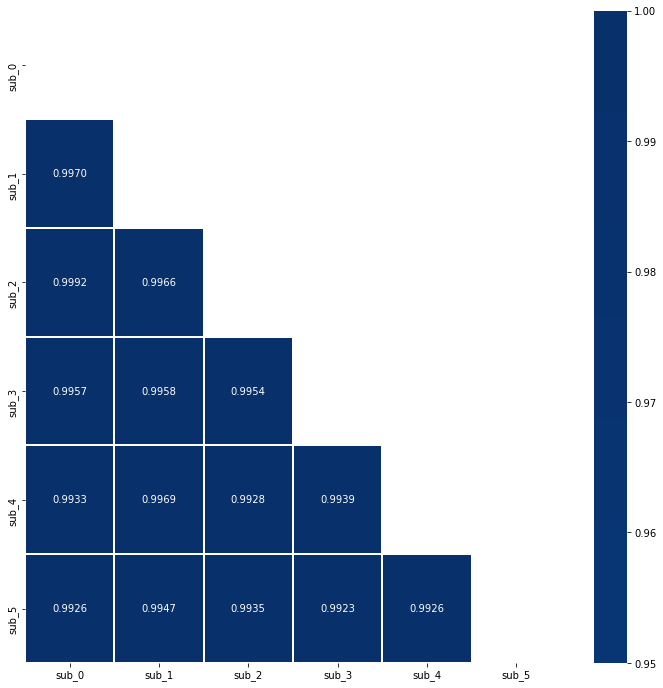

In [100]:
corr = predictions.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr, mask=mask, cmap='Blues', vmin=0.95, center=0, linewidths=1, annot=True, fmt='.4f')
plt.show()